# Architecture

We have created a pipeline to combine datasets and relabel the data based on a new name. Additionally, this framework allows us to create "projects" that record training sessions, including the parameters and weights of the model for each training session. Our experiments include three such projects:

__binary_classification__ - Model trained to determine if pneumonia is present in a chest xray.

__binary_classification_with_edge_detection__ - Model trained to determine if pneumonia is present in a chest xray but additional preprocessing occurs using Canny edge detection

__multi_classification__ - Model trained to determine the precense (or lack there of) of multiple ailment types.

In [49]:
from pneumonia_dnn.dataset import update_dataset_from_metadata, create_dataset, DatasetClassifier
from pneumonia_dnn.project import create_project
import shutil
from pneumonia_dnn.project import apply_augmentations
from pneumonia_dnn.models.cnn import run_cnn
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
from keras import backend
from pneumonia_dnn.models.vit import run_vit
from pneumonia_dnn.models.vgg16 import run_vgg16
from pneumonia_dnn.models.vitb16 import run_vitb16
import PIL.Image
import glob
import os
import pandas as pd
from pandas import DataFrame
import random
from sklearn.metrics import ConfusionMatrixDisplay


def plot_history(history, item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

def display_random_images(folder_path: str, num_images: int=10):
    if not os.path.exists(folder_path):
        print("The specified folder does not exist.")
        return

    files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))]

    if not files:
        print("No images found in the specified folder.")
        return

    selected_files = random.sample(files, min(num_images, len(files)))

    num_cols = int(num_images**0.5)
    num_rows = (num_images + num_cols - 1) // num_cols  # Ensure all images fit in the grid

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))

    axs = axs.ravel() if num_images > 1 else [axs]

    for ax, file_path in zip(axs, selected_files):
        img = PIL.Image.open(file_path)
        ax.imshow(img)
        ax.axis('off')  # Hide axes

    # If there are any empty subplots, turn off their axes
    for ax in axs[len(selected_files):]:
        ax.axis('off')

    plt.show()


epochs = 50
batch_size= 32


# Dataset Creation

Initially, a new datadataset is created for binary classification. The __create_dataset__ function only establishes folder structure and metadata for a dataset. The __update_dataset_from_metadata__ provides a mechanism for loading data from a kaggle dataset into the dataset created with __create_dataset__. Additionally, this function provides the capability of being able to relabel the data. Multiple calls to __update_dataset_from_metadata__ works as an aggregation of the kaggle datasets.

In [2]:
shutil.rmtree("datasets/pneumonia_binary_classification", ignore_errors=True)

create_dataset("pneumonia_binary_classification", "Chest X-Rays used for binary classification of pneumonia")

# Add data from Coronahack-chest-xray dataset
# source: https://www.kaggle.com/datasets/praveengovi/coronahack-chest-xraydataset
update_dataset_from_metadata(
                        "pneumonia_binary_classification",
                        "praveengovi/coronahack-chest-xraydataset",
                        "https://www.kaggle.com/datasets/praveengovi/coronahack-chest-xraydataset",
                        "Chest_xray_Corona_Metadata.csv",
                        label_column="Label",
                        labels=[
                            DatasetClassifier("pneumonia", "Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset", "Pnemonia", True),
                            DatasetClassifier("nonpneumonia",  "Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset", "Normal", True)
                        ],
                        image_column="X_ray_image_name",
                        folder_column="Dataset_type",
                        folder_to_lower=True,
                        download_path="downloads",
                        dataset_path="datasets" )

# Add data from the Sampl NIH Dataset
# source: https://www.kaggle.com/datasets/nih-chest-xrays/sample
update_dataset_from_metadata(
                        "pneumonia_binary_classification",
                        "sample",
                        "https://www.kaggle.com/datasets/nih-chest-xrays/sample",
                        "sample_labels.csv",
                        label_column="Finding Labels",
                        labels=[
                            DatasetClassifier("pneumonia", "sample/images", "Pneumonia", True),
                            DatasetClassifier("nonpneumonia",  "sample/images", "Pneumonia", False)
                        ],
                        image_column="Image Index",
                        folder_column=None,
                        folder_to_lower=True,
                        download_path="downloads",
                        dataset_path="datasets" )

/home/ubuntu/workspace/Pneumonia-DNN/pneumonia_dnn/dataset.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_df[image_column] = (
/home/ubuntu/workspace/Pneumonia-DNN/pneumonia_dnn/dataset.py:212: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_df[image_column] = (


# Create Project

Creating a project takes a random sampling of images for the provided dataset. In this following example, the name of the project is __binary_classification__ and the dataset that it will take a random sampling from is __pneumonia_binary_classification__. The size of the sample that is will take from the dataset is 8600 images. These images will be split into train (0.7) and test data (0.3). Additionally, the image size value is passed in project initialization. All images will be resized to 256x256 during training. 

In [3]:
shutil.rmtree("projects/binary_classification", ignore_errors=True)
binary_classification_project = create_project("binary_classification", "pneumonia_binary_classification", 256, 256, 3, None, 0.7, 8600, None)
seed = binary_classification_project["seed"]
random.seed(seed)

binary_classification_project

Processing test for label nonpneumonia: 100%|██████████| 1290/1290 [00:01<00:00, 752.08it/s]


{'name': 'binary_classification',
 'max_images': 8600,
 'total_train': 6020,
 'total_test': 2580,
 'train_counts': {'pneumonia': 3010, 'nonpneumonia': 3010},
 'test_counts': {'pneumonia': 1290, 'nonpneumonia': 1290},
 'training_path': 'projects/binary_classification/dataset/train',
 'testing_path': 'projects/binary_classification/dataset/test',
 'seed': 7,
 'image_width': 256,
 'image_height': 256,
 'image_channels': 3,
 'labels': ['pneumonia', 'nonpneumonia']}

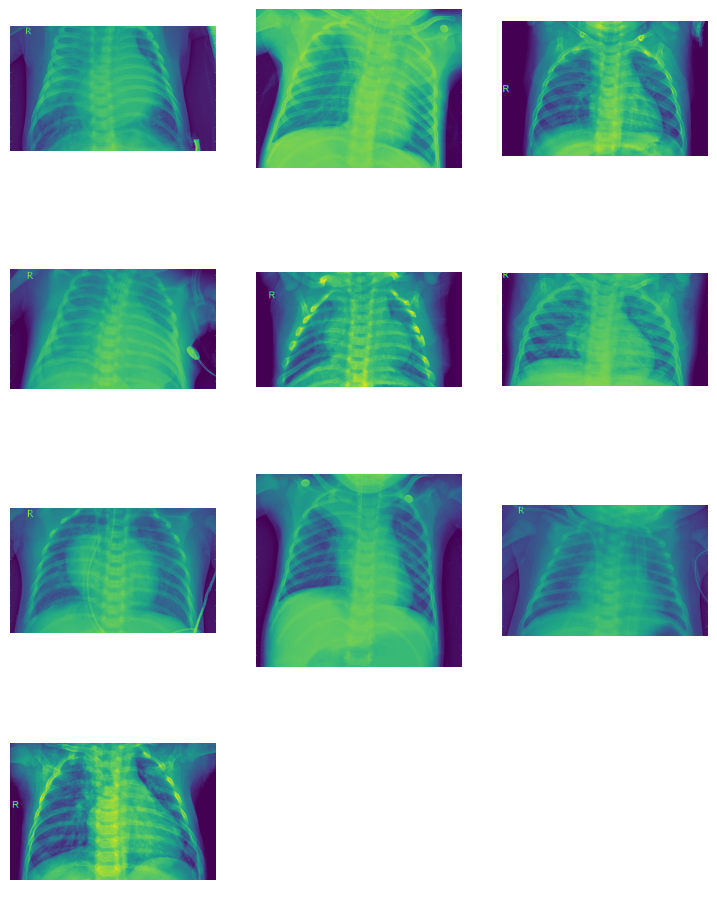

In [4]:
display_random_images('projects/binary_classification/dataset/train/pneumonia/')

Random selection of images from the training dataset with penumonia

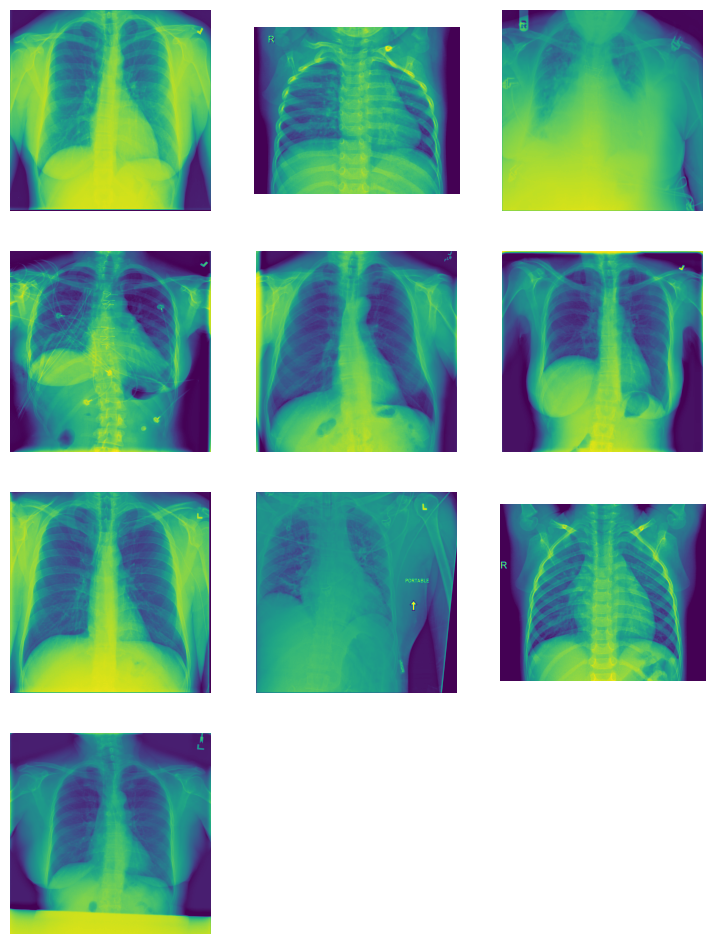

In [5]:
display_random_images('projects/binary_classification/dataset/train/nonpneumonia/')

Random selection of images without pneumonia in the training dataset.

Text(0.5, 0.98, 'Dimensions of Images')

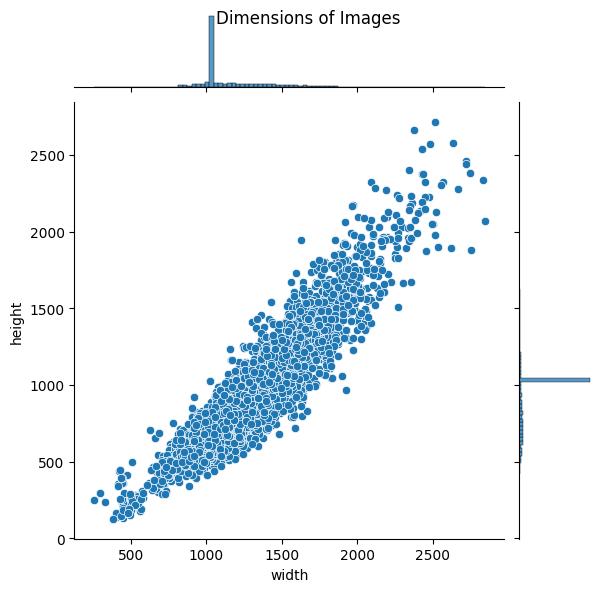

In [6]:
dataset_df = pd.read_csv(
        f"projects/binary_classification/dataset/__metadata.csv"
    )

p = sns.jointplot(x = "width", y = "height", data = dataset_df)
p.figure.suptitle("Dimensions of Images")

This plot can provide insight into which sizes are optimal for training. Based on this graph the optimal size is 1024x1024 but that is too large for our current hardware and can cause resource exhaustion. Instead, we will be using 256x256 which still falls within the linear trend of the graph.

In [7]:
apply_augmentations("binary_classification", 0.2, 0.2, True, True, 0.02)

The framework allows for applying image augmentations to the project. These settings are stored in a configuration file and used during training. The actual augmentation is done in preprocessing layers during training.

# Model Creation, Training, and Evaluation

A function for each of our model types (convolutional neural network, vision transformer, pretrained VGG16, & pretrained Vision Transform - B16) expose a __run__ function that takes a project name and hyperparameters as inputs and returns the model, training history, confusion matrix data, loss, and accuracy. The __run__ functions create an instance of the model, loads the dataset from the given project, trains the model, and evaluates the model.

## Binary Classification - Convolutional Neural Network

Found 6020 files belonging to 2 classes.
Found 2580 files belonging to 2 classes.
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
81/81 [==============================] - 6s 62ms/step - loss: 0.1349 - binary_accuracy: 0.9628


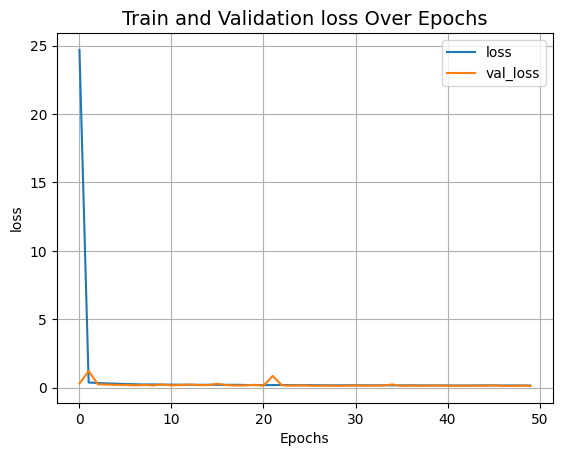

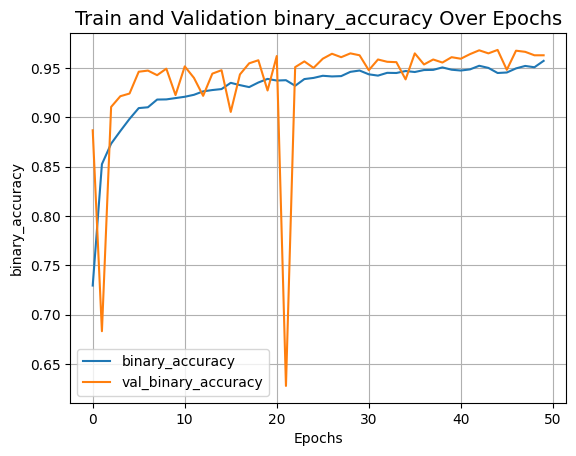

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 256, 256, 3)       7         
 ial)                                                            
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0     

In [50]:
backend.clear_session()
cnn_model, cnn_history, cnn_predictions, cnn_confusion_matrix_data, cnn_loss, cnn_accuracy = run_cnn("binary_classification", epochs=epochs, batch_size=batch_size, use_adam_optimizer=False)
plot_history(cnn_history, "loss")
plot_history(cnn_history, "binary_accuracy")
backend.clear_session()
cnn_model.summary()

In [9]:
print(f"Loss - {cnn_loss}. Accuracy - {cnn_accuracy}")

Loss - 0.12944409251213074. Accuracy - 0.9627906680107117


The first model is a convolutional neural network using the RMSProp optimizer function. This model preformed very well seeing ~95% accuracy and loss of ~0.17. There are some some epochs that have significant divergence between the training and test accuracies which ___may be___ an indicator of overfitting and is worth further exploration.

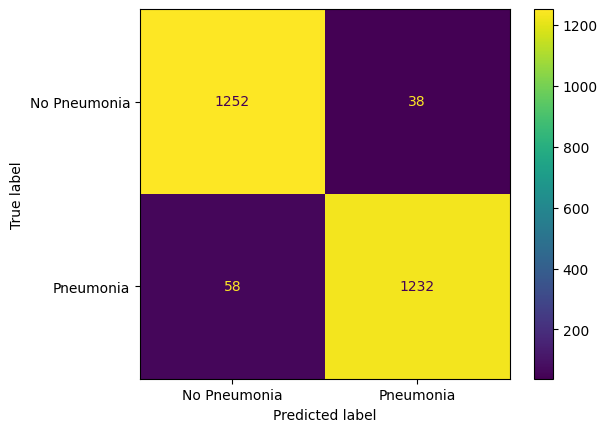

In [10]:
disp = ConfusionMatrixDisplay(confusion_matrix=cnn_confusion_matrix_data, display_labels=['No Pneumonia', 'Pneumonia'])
disp.plot()
plt.show()

The CNN model surprisingly had no false-positives or false-negatives according to the confusion matrix which would indicate that the overfitting may not be a concern.

Found 6020 files belonging to 2 classes.
Found 2580 files belonging to 2 classes.
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
81/81 [==============================] - 5s 61ms/step - loss: 0.1159 - binary_accuracy: 0.9651


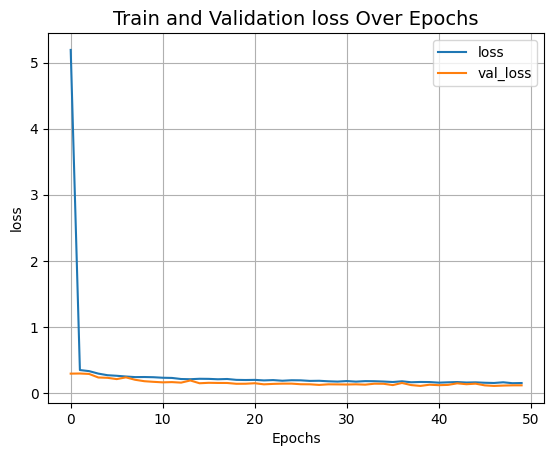

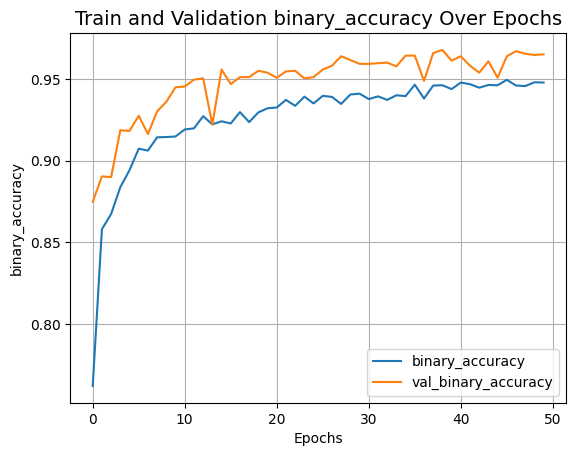

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 256, 256, 3)       7         
 ial)                                                            
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0     

In [11]:
backend.clear_session()
cnn_model, cnn_history, cnn_predictions, cnn_confusion_matrix_data, cnn_loss, cnn_accuracy = run_cnn("binary_classification", epochs=epochs, batch_size=batch_size, use_adam_optimizer=True)
plot_history(cnn_history, "loss")
plot_history(cnn_history, "binary_accuracy")
backend.clear_session()
cnn_model.summary()

The second model is a convolutional neural network using the Adam optimizer function. 

In [12]:
print(f"CNN Loss - {cnn_loss}. Accuracy - {cnn_accuracy}")

CNN Loss - 0.11586171388626099. Accuracy - 0.9651162624359131


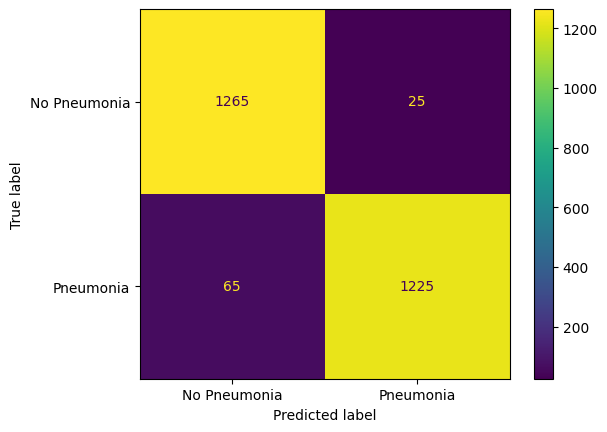

In [13]:
disp = ConfusionMatrixDisplay(confusion_matrix=cnn_confusion_matrix_data, display_labels=['No Pneumonia', 'Pneumonia'])
disp.plot()
plt.show()

## Binary Classification - Vision Transformer

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


2024-04-26 17:36:53.385285: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Found 6020 files belonging to 2 classes.
Found 2580 files belonging to 2 classes.
Epoch 1/50
189/189 [==============================] - 78s 343ms/step - loss: 1.9125 - binary_accuracy: 0.5422 - val_loss: 0.5918 - val_binary_accuracy: 0.6023
Epoch 2/50
189/189 [==============================] - 65s 341ms/step - loss: 0.6413 - binary_accuracy: 0.6385 - val_loss: 0.4617 - val_binary_accuracy: 0.8469
Epoch 3/50
189/189 [==============================] - 65s 342ms/step - loss: 0.5287 - binary_accuracy: 0.7347 - val_loss: 0.3854 - val_binary_accuracy: 0.8562
Epoch 4/50
189/189 [==============================] - 65s 342ms/step - loss: 0.4571 - binary_accuracy: 0.7960 - val_loss: 0.3588 - val_binary_accuracy: 0.8585
Epoch 5/50
189/189 [==============================] - 65s 342ms/step - loss: 0.4085 - binary_accuracy: 0.8239 - val_loss: 0.3608 - val_binary_accuracy: 0.8612
Epoch 6/50
189/189 [==============================] - 65s 343ms/step - loss: 0.4031 - binary_accuracy: 0.8324 - val_loss: 0

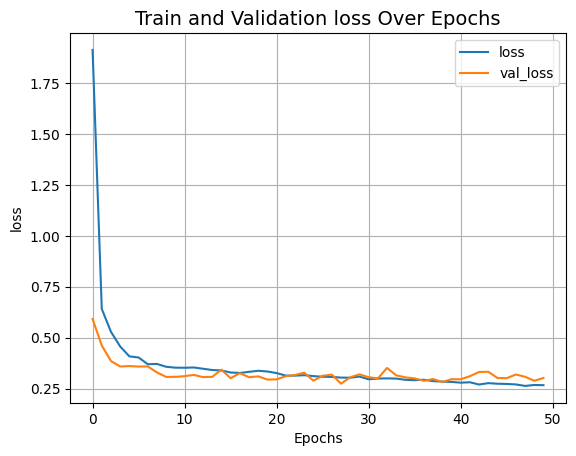

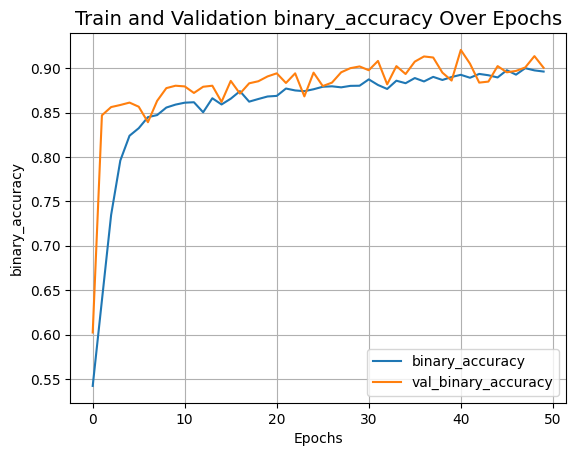

In [14]:
transformer_layers=3
num_heads=2
vit_model, vit_history, vit_predictions, vit_confusion_matrix_data, vit_loss, vit_accuracy = run_vit("binary_classification", epochs=epochs, batch_size=batch_size, transformer_layers=transformer_layers, num_heads=num_heads)

plot_history(vit_history, "loss")
plot_history(vit_history, "binary_accuracy")
backend.clear_session()

The third model we attempted was a Vision Transformer architecture. 

In [15]:
print(f"ViT Loss - {vit_loss}. Accuracy - {vit_accuracy}")

ViT Loss - 0.3025949001312256. Accuracy - 0.9003875851631165


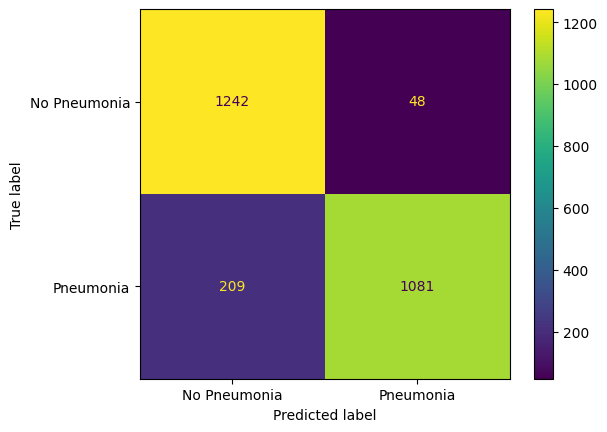

In [16]:
disp = ConfusionMatrixDisplay(confusion_matrix=vit_confusion_matrix_data, display_labels=['No Pneumonia', 'Pneumonia'])
disp.plot()
plt.show()

## Binary Classification - Pretrained CNN - VGG16

Found 6020 files belonging to 2 classes.
Found 2580 files belonging to 2 classes.
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
81/81 [==============================] - 6s 67ms/step - loss: 0.1264 - binary_accuracy: 0.9674


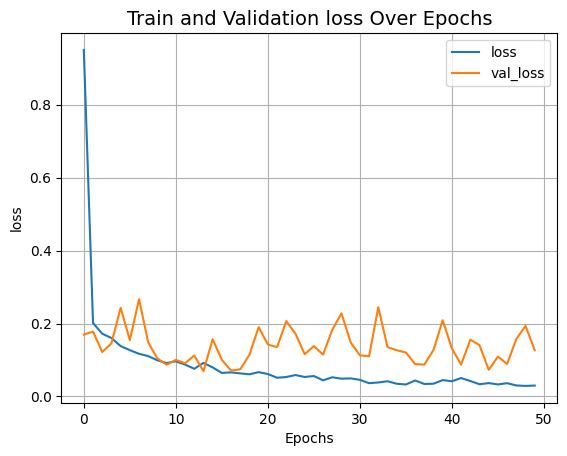

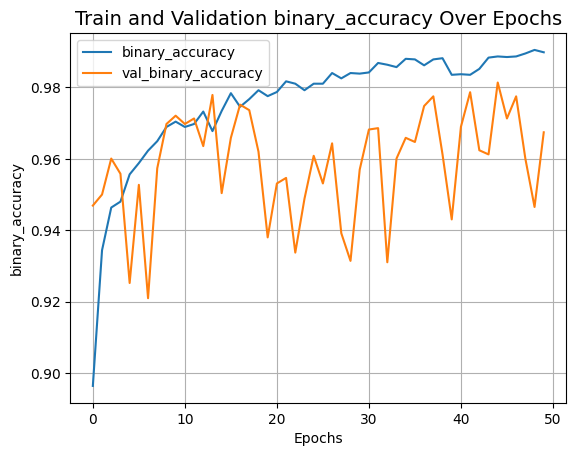

In [17]:
vgg_model, vgg_history, vgg_predictions, vgg_confusion_matrix_data, vgg_loss, vgg_accuracy = run_vgg16("binary_classification", epochs=epochs)

plot_history(vgg_history, "loss")
plot_history(vgg_history, "binary_accuracy")
backend.clear_session()

In [18]:
print(f"VGG Loss - {vgg_loss}. Accuracy - {vgg_accuracy}")

VGG Loss - 0.1263960301876068. Accuracy - 0.9674418568611145


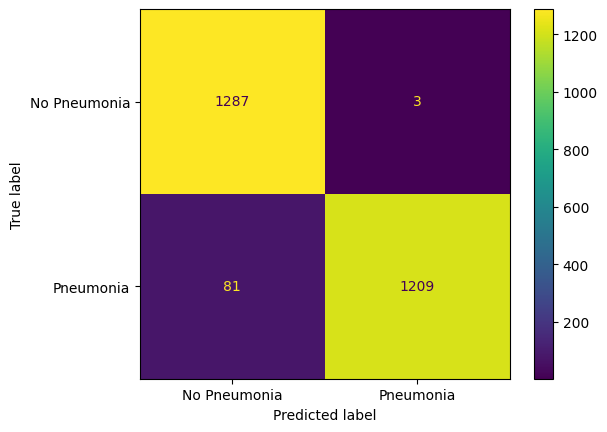

In [19]:
disp = ConfusionMatrixDisplay(confusion_matrix=vgg_confusion_matrix_data, display_labels=['No Pneumonia', 'Pneumonia'])
disp.plot()
plt.show()

## Binary Classification - Pretrained Vision Transformer - B16

Found 6020 files belonging to 2 classes.
Found 2580 files belonging to 2 classes.


/opt/tensorflow/lib/python3.10/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 16, 16
  warnings.warn(


Epoch 1/50
189/189 [==============================] - 83s 374ms/step - loss: 0.7270 - binary_accuracy: 0.4889 - val_loss: 0.6857 - val_binary_accuracy: 0.5353
Epoch 2/50
189/189 [==============================] - 69s 361ms/step - loss: 0.6943 - binary_accuracy: 0.5349 - val_loss: 0.6592 - val_binary_accuracy: 0.6601
Epoch 3/50
189/189 [==============================] - 69s 361ms/step - loss: 0.6678 - binary_accuracy: 0.5895 - val_loss: 0.6348 - val_binary_accuracy: 0.7279
Epoch 4/50
189/189 [==============================] - 69s 361ms/step - loss: 0.6469 - binary_accuracy: 0.6344 - val_loss: 0.6142 - val_binary_accuracy: 0.7659
Epoch 5/50
189/189 [==============================] - 69s 362ms/step - loss: 0.6324 - binary_accuracy: 0.6465 - val_loss: 0.5988 - val_binary_accuracy: 0.7554
Epoch 6/50
189/189 [==============================] - 69s 362ms/step - loss: 0.6137 - binary_accuracy: 0.6718 - val_loss: 0.5811 - val_binary_accuracy: 0.7969
Epoch 7/50
189/189 [==========================

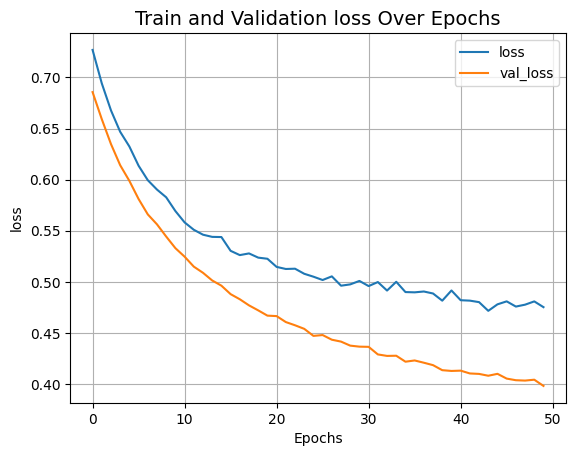

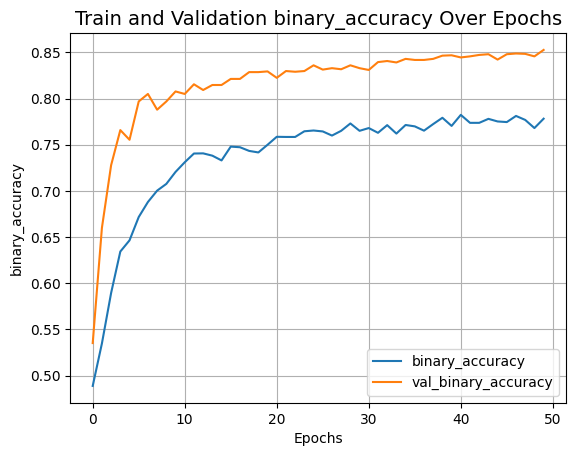

In [20]:
vitb16_model, vitb16_history, vitb16_predictions, vitb16_confusion_matrix_data, vitb16_loss, vitb16_accuracy = run_vitb16("binary_classification", epochs=epochs)

plot_history(vitb16_history, "loss")
plot_history(vitb16_history, "binary_accuracy")
backend.clear_session()

In [21]:
print(f"ViTB16 Loss - {vitb16_loss}. Accuracy - {vitb16_accuracy}")

ViTB16 Loss - 0.39815738797187805. Accuracy - 0.8527131676673889


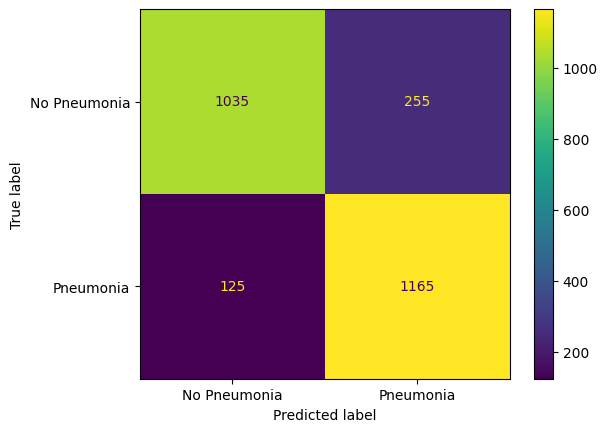

In [22]:
disp = ConfusionMatrixDisplay(confusion_matrix=vitb16_confusion_matrix_data, display_labels=['No Pneumonia', 'Pneumonia'])
disp.plot()
plt.show()

# Multi-Class Classification

The framework allows for simple transition between binary classification and multi-class classification by simply adding additional __DatasetClassifiers__ to a create dataset.

In [23]:
shutil.rmtree("datasets/pneumonia_multi_classification", ignore_errors=True)

create_dataset("pneumonia_multi_classification", "Chest X-Rays used for multi-classification of pneumonia, healthy, and pleural thickening chest")

# Add data from Coronahack-chest-xray dataset
# source: https://www.kaggle.com/datasets/praveengovi/coronahack-chest-xraydataset
update_dataset_from_metadata(
                        "pneumonia_multi_classification",
                        "praveengovi/coronahack-chest-xraydataset",
                        "https://www.kaggle.com/datasets/praveengovi/coronahack-chest-xraydataset",
                        "Chest_xray_Corona_Metadata.csv",
                        label_column="Label",
                        labels=[
                            DatasetClassifier("pneumonia", "Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset", "Pnemonia", True),
                            DatasetClassifier("healthy",  "Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset", "Normal", True)
                        ],
                        image_column="X_ray_image_name",
                        folder_column="Dataset_type",
                        folder_to_lower=True,
                        download_path="downloads",
                        dataset_path="datasets" )

# Add data from the Sampl NIH Dataset
# source: https://www.kaggle.com/datasets/nih-chest-xrays/sample
update_dataset_from_metadata(
                        "pneumonia_multi_classification",
                        "sample",
                        "https://www.kaggle.com/datasets/nih-chest-xrays/sample",
                        "sample_labels.csv",
                        label_column="Finding Labels",
                        labels=[
                            DatasetClassifier("pneumonia", "sample/images", "Pneumonia", True),
                            DatasetClassifier("healthy",  "sample/images", "No Finding", True),
                            DatasetClassifier("pleural_thickening",  "sample/images", "Pleural_Thickening", True),
                        ],
                        image_column="Image Index",
                        folder_column=None,
                        folder_to_lower=True,
                        download_path="downloads",
                        dataset_path="datasets" )

/home/ubuntu/workspace/Pneumonia-DNN/pneumonia_dnn/dataset.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_df[image_column] = (
/home/ubuntu/workspace/Pneumonia-DNN/pneumonia_dnn/dataset.py:212: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_df[image_column] = (


## Multi-Class Classification - Convolutional Neural Network

In [24]:
shutil.rmtree("projects/multi_classification", ignore_errors=True)
multi_classification_project = create_project("multi_classification", "pneumonia_multi_classification", 256, 256, 3, None, 0.7, 525, None)
seed = multi_classification_project["seed"]
random.seed(seed)

multi_classification_project

Processing test for label pleural_thickening: 100%|██████████| 53/53 [00:00<00:00, 2830.67it/s]


{'name': 'multi_classification',
 'max_images': 525,
 'total_train': 368,
 'total_test': 157,
 'train_counts': {'pneumonia': 123, 'healthy': 123, 'pleural_thickening': 123},
 'test_counts': {'pneumonia': 53, 'healthy': 53, 'pleural_thickening': 53},
 'training_path': 'projects/multi_classification/dataset/train',
 'testing_path': 'projects/multi_classification/dataset/test',
 'seed': 1,
 'image_width': 256,
 'image_height': 256,
 'image_channels': 3,
 'labels': ['pneumonia', 'healthy', 'pleural_thickening']}

Text(0.5, 0.98, 'Dimensions of Images')

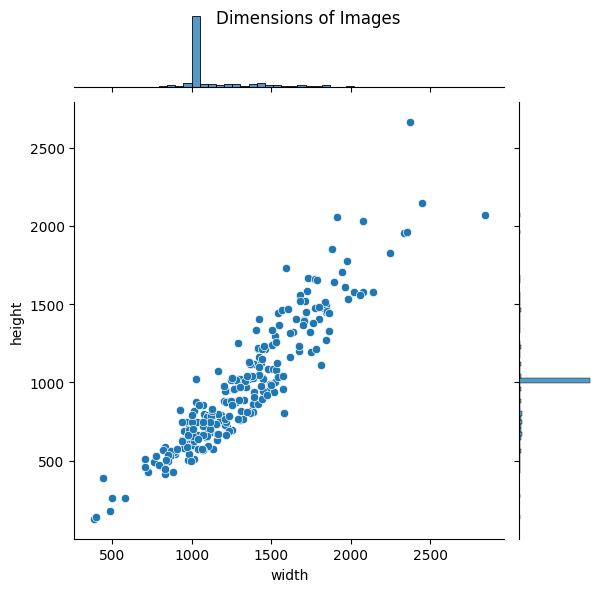

In [25]:
dataset_df = pd.read_csv(
        f"projects/multi_classification/dataset/__metadata.csv"
    )

p = sns.jointplot(x = "width", y = "height", data = dataset_df)
p.figure.suptitle("Dimensions of Images")

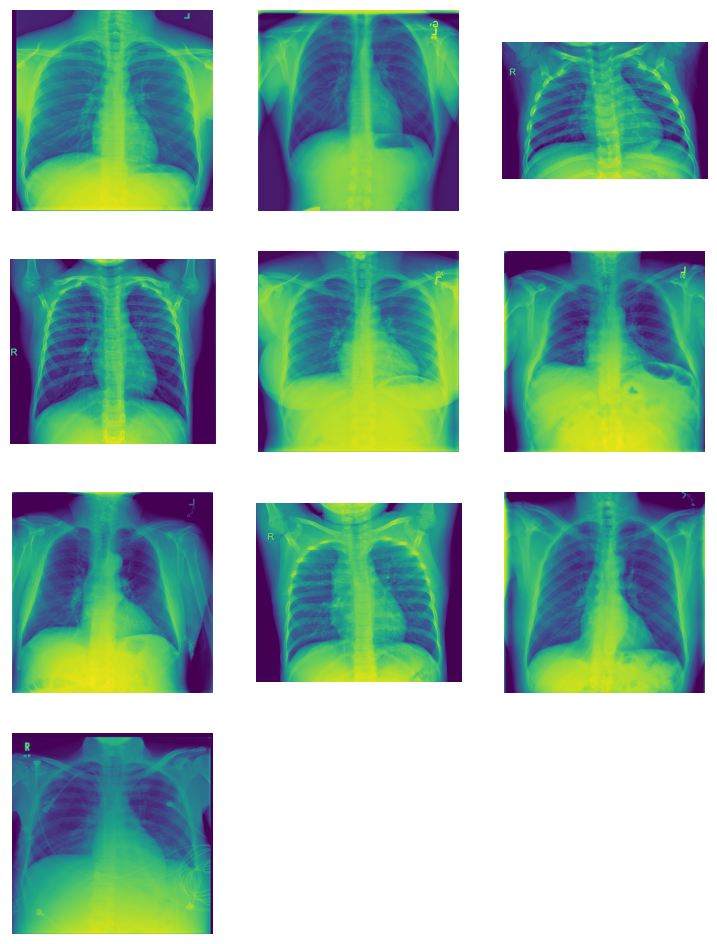

In [26]:
display_random_images('projects/multi_classification/dataset/train/healthy/')

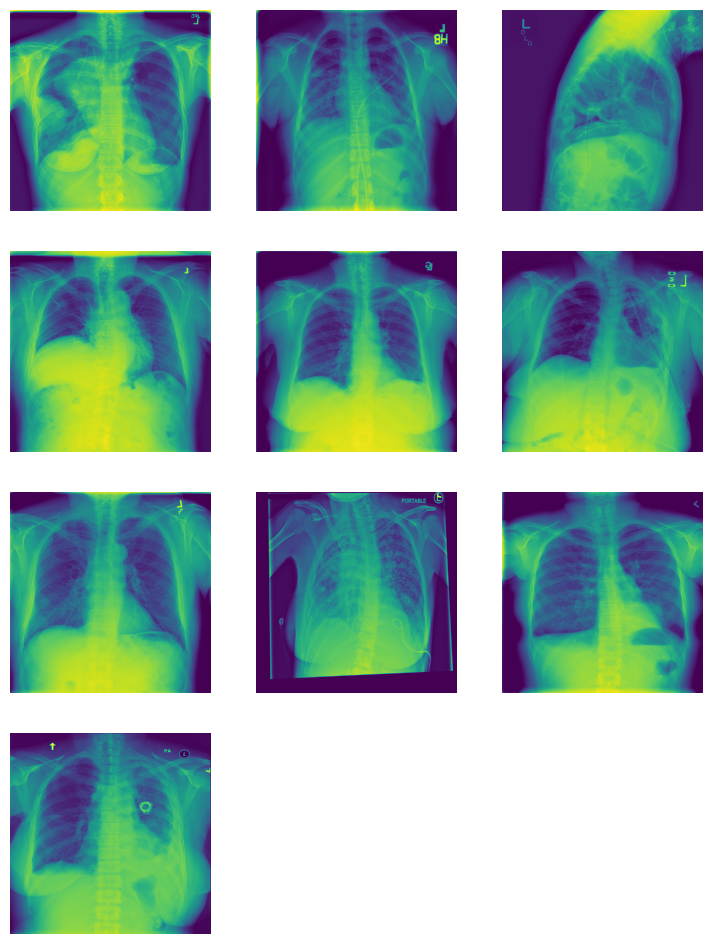

In [27]:
display_random_images('projects/multi_classification/dataset/train/pleural_thickening/')

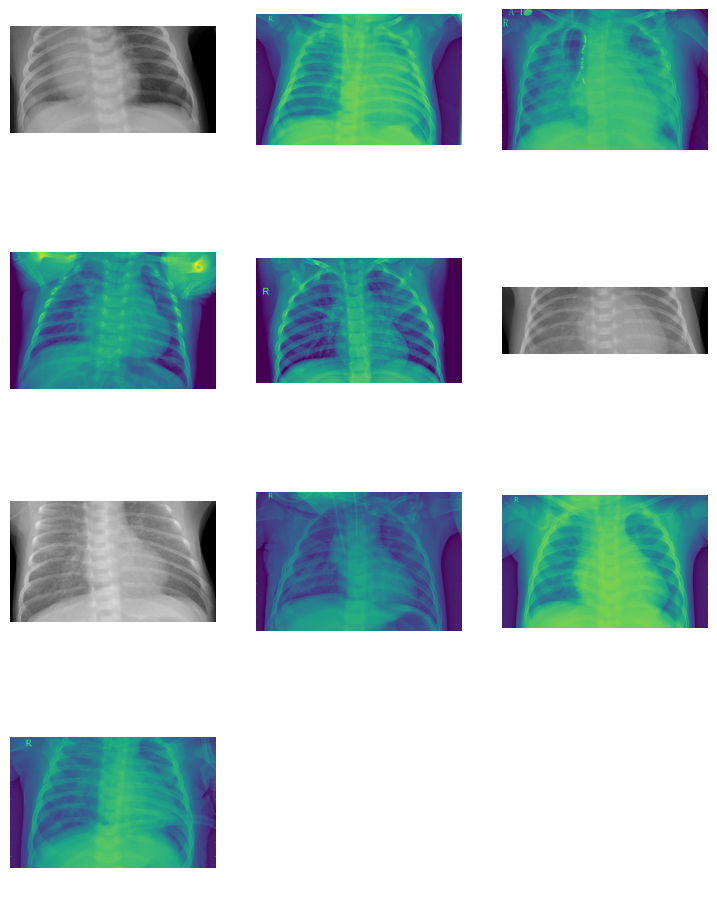

In [28]:
display_random_images('projects/multi_classification/dataset/train/pneumonia/')

In [29]:
apply_augmentations("multi_classification", 0.2, 0.2, True, True, 0.02)

Found 369 files belonging to 3 classes.
Found 159 files belonging to 3 classes.
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 

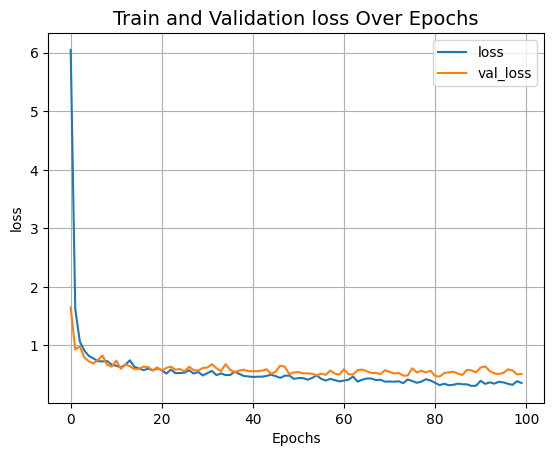

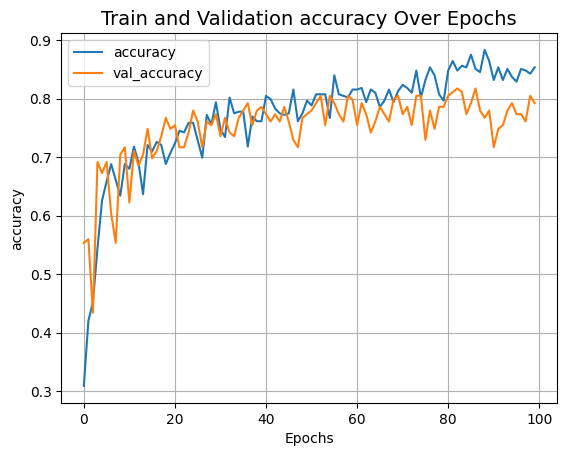

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 256, 256, 3)       7         
 ial)                                                            
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0     

In [30]:
backend.clear_session()
batch_size=128
epochs=100
cnn_model, cnn_history, cnn_predictions, cnn_confusion_matrix_data, cnn_loss, cnn_accuracy = run_cnn("multi_classification", epochs=epochs, batch_size=batch_size, cnn_neurons=[16,32,64,128,256,512], dropout_rate=0.4, use_adam_optimizer=True)
plot_history(cnn_history, "loss")
plot_history(cnn_history, "accuracy")
backend.clear_session()
cnn_model.summary()

In [31]:
print(f"Multi-Class CNN Loss - {cnn_loss}. Accuracy - {cnn_accuracy}")

Multi-Class CNN Loss - 0.5133355855941772. Accuracy - 0.7924528121948242


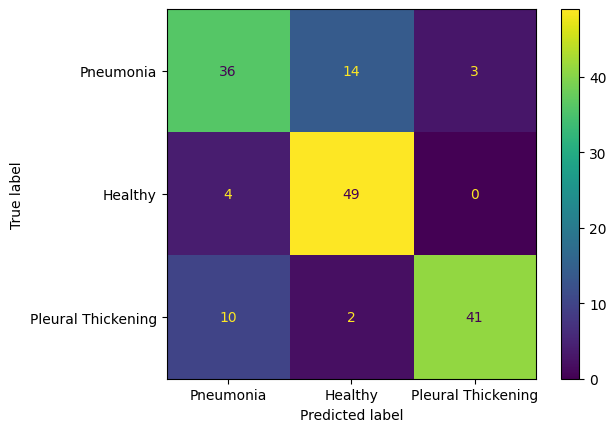

In [32]:
disp = ConfusionMatrixDisplay(confusion_matrix=cnn_confusion_matrix_data, display_labels=['Pneumonia', 'Healthy', "Pleural Thickening"])
disp.plot()
plt.show()

Found 369 files belonging to 3 classes.
Found 159 files belonging to 3 classes.
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 

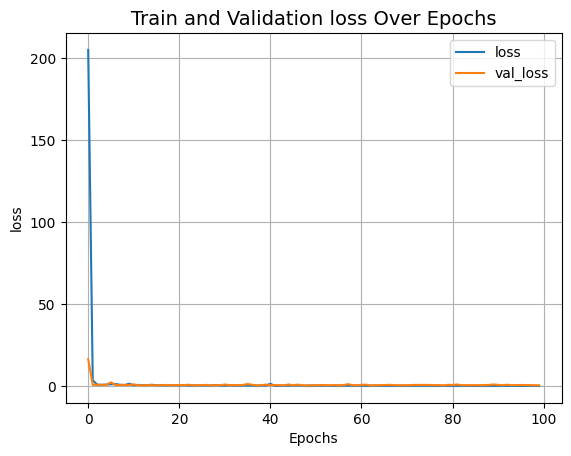

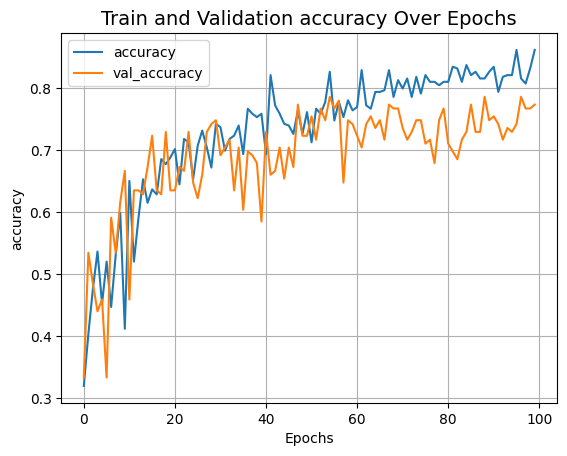

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 256, 256, 3)       7         
 ial)                                                            
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 84, 84, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 82, 82, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 27, 27, 32)        0     

In [33]:
backend.clear_session()
batch_size=128
epochs=100
cnn_model, cnn_history, cnn_predictions, cnn_confusion_matrix_data, cnn_loss, cnn_accuracy = run_cnn("multi_classification", epochs=epochs, batch_size=batch_size, learning_rate=0.001, pooling_size=3, pooling_stride=3, dropout_rate=0.4, use_adam_optimizer=False)
plot_history(cnn_history, "loss")
plot_history(cnn_history, "accuracy")
backend.clear_session()
cnn_model.summary()

Found 369 files belonging to 3 classes.
Found 159 files belonging to 3 classes.
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 

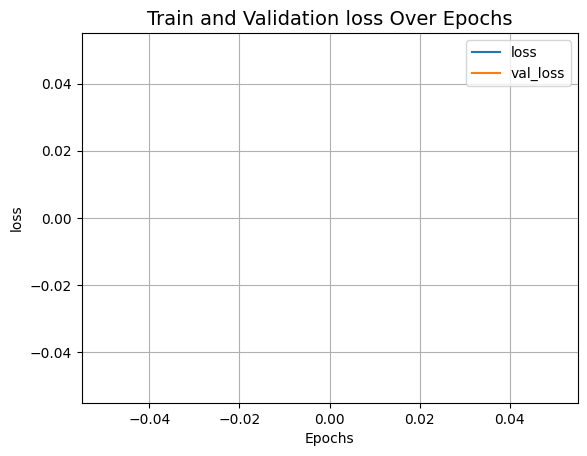

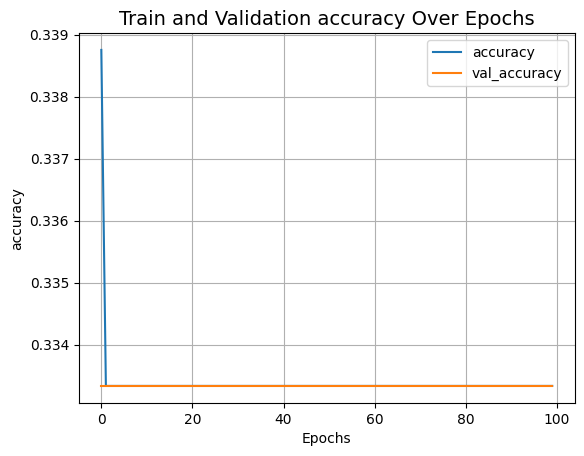

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 256, 256, 3)       7         
 ial)                                                            
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0     

In [34]:
backend.clear_session()
batch_size=32
epochs=100
cnn_model, cnn_history, cnn_predictions, cnn_confusion_matrix_data, cnn_loss, cnn_accuracy = run_cnn("multi_classification", epochs=epochs, batch_size=batch_size, learning_rate=0.01, pooling_size=2, pooling_stride=2, cnn_neurons=[16,32,64,128,512,1024], dense_layer_neurons=1024, dropout_rate=0.2, use_adam_optimizer=False)
plot_history(cnn_history, "loss")
plot_history(cnn_history, "accuracy")
backend.clear_session()
cnn_model.summary()

# Binary Classification with edge detection

In [35]:
shutil.rmtree("projects/binary_classification_with_edge_detection", ignore_errors=True)
binary_classification_project = create_project("binary_classification_with_edge_detection", "pneumonia_binary_classification", 256, 256, 3, None, 0.7, 8600, None, apply_edge_detection=True, edge_detection_threshold1=20, edge_detection_threshold2=40)
seed = binary_classification_project["seed"]
random.seed(seed)

binary_classification_project

Processing test for label nonpneumonia: 100%|██████████| 1290/1290 [00:46<00:00, 27.83it/s]


{'name': 'binary_classification_with_edge_detection',
 'max_images': 8600,
 'total_train': 6020,
 'total_test': 2580,
 'train_counts': {'pneumonia': 3010, 'nonpneumonia': 3010},
 'test_counts': {'pneumonia': 1290, 'nonpneumonia': 1290},
 'training_path': 'projects/binary_classification_with_edge_detection/dataset/train',
 'testing_path': 'projects/binary_classification_with_edge_detection/dataset/test',
 'seed': 0,
 'image_width': 256,
 'image_height': 256,
 'image_channels': 3,
 'labels': ['pneumonia', 'nonpneumonia']}

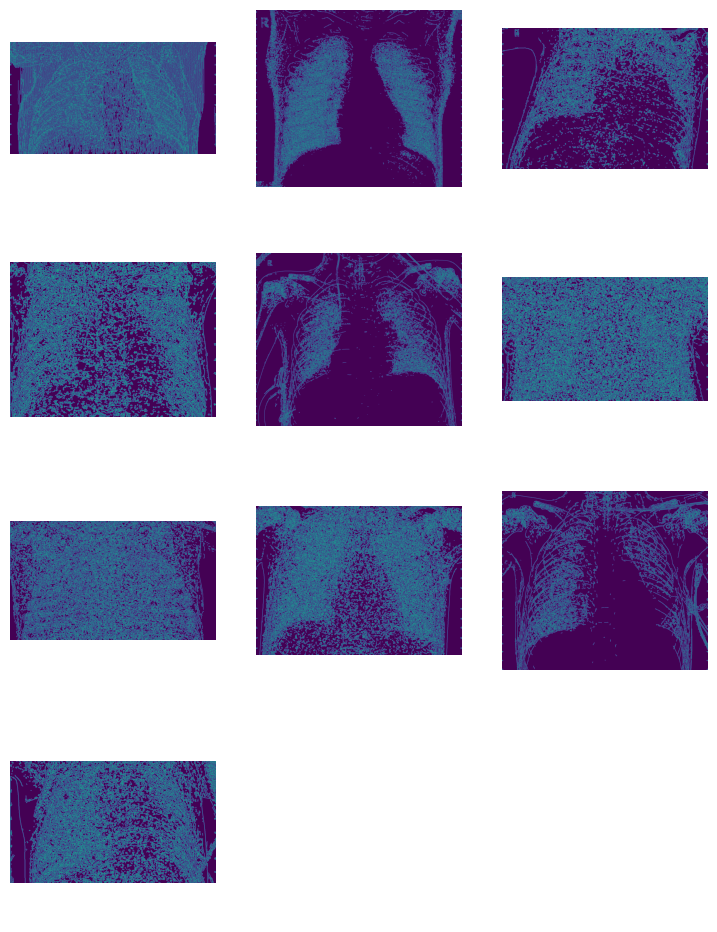

In [36]:
display_random_images('projects/binary_classification_with_edge_detection/dataset/train/pneumonia/')

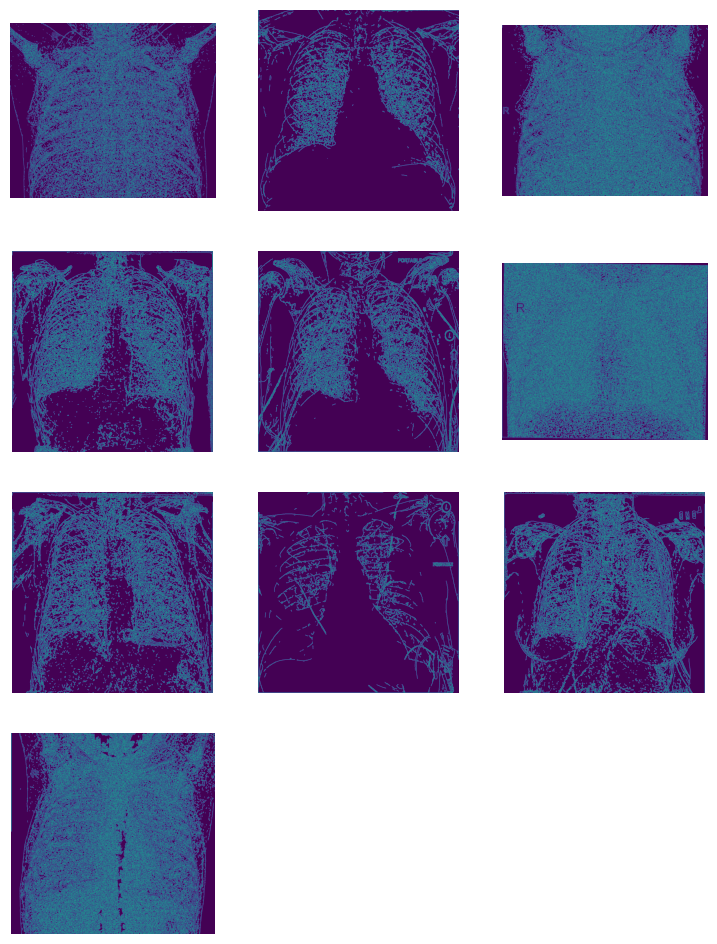

In [37]:
display_random_images('projects/binary_classification_with_edge_detection/dataset/train/nonpneumonia/')

Text(0.5, 0.98, 'Dimensions of Images')

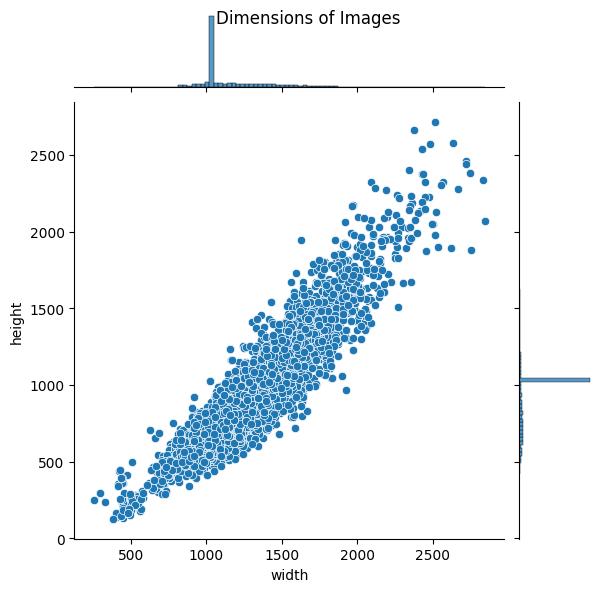

In [38]:
dataset_df = pd.read_csv(
        f"projects/binary_classification_with_edge_detection/dataset/__metadata.csv"
    )

p = sns.jointplot(x = "width", y = "height", data = dataset_df)
p.figure.suptitle("Dimensions of Images")

In [39]:
apply_augmentations("binary_classification_with_edge_detection", 0.2, 0.2, True, True, 0.02)

In [40]:
backend.clear_session()
cnn_model, cnn_history, cnn_predictions, cnn_confusion_matrix_data, cnn_loss, cnn_accuracy = run_cnn("binary_classification_with_edge_detection", epochs=epochs, batch_size=batch_size, use_adam_optimizer=True)
plot_history(cnn_history, "loss")
plot_history(cnn_history, "binary_accuracy")
backend.clear_session()
cnn_model.summary()

Found 6020 files belonging to 2 classes.
Found 2580 files belonging to 2 classes.
Epoch 1/100
Epoch 2/100


KeyboardInterrupt: 

In [ ]:
print(f"Loss - {cnn_loss}. Accuracy - {cnn_accuracy}")

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cnn_confusion_matrix_data, display_labels=['No Pneumonia', 'Pneumonia'])
disp.plot()
plt.show()

# Final Analysis

In [59]:
import numpy as np
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score, accuracy_score
from pneumonia_dnn.utils import get_labels_and_predictions, get_project_datasets

_, test_dataset = get_project_datasets("binary_classification")
labels, preds = get_labels_and_predictions(test_dataset, cnn_model, batch_size=32, num_classes=2)

print(f'Accuracy: {accuracy_score(labels, preds)}')
print(f'Precision: {precision_score(labels, preds, average=None)}')
print(f'Recall: {recall_score(labels, preds, average=None)}')
print(f'F1: {f1_score(labels, preds, average=None)}')

Found 6020 files belonging to 2 classes.
Found 2580 files belonging to 2 classes.
1/1 [==============================] - 0s 31ms/step
Accuracy: 0.9627906976744186
Precision: [0.95227273 0.97380952]
Recall: [0.9744186  0.95116279]
F1: [0.96321839 0.96235294]


In [62]:
_, test_dataset = get_project_datasets("binary_classification")
labels, preds = get_labels_and_predictions(test_dataset, vitb16_model, batch_size=32, num_classes=2)

print(f'Accuracy: {accuracy_score(labels, preds)}')
print(f'Precision: {precision_score(labels, preds, average=None)}')
print(f'Recall: {recall_score(labels, preds, average=None)}')
print(f'F1: {f1_score(labels, preds, average=None)}')

Found 6020 files belonging to 2 classes.
Found 2580 files belonging to 2 classes.
1/1 [==============================] - 1s 1s/step
Accuracy: 0.8527131782945736
Precision: [0.89224138 0.82042254]
Recall: [0.80232558 0.90310078]
F1: [0.84489796 0.8597786 ]
